# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive


-----

## Getting Started
In this project, we will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |


In [2]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline


From the `/smartcab/` top-level directory (where this notebook is located), we can launch simulation running the command:
```bash
'python smartcab/agent.py'
```

The smartcab does not move at all during the simulation. That can be explained by the fact that the agent has not been enforced to meet a deadline, and that there is no implementation (yet) to update agent state after each step.

The driving agent recieves multiple kinds of 'positive' rewards based on light changing colors:
- if it properly stops at a red light
- if it stops at a green light with oncoming traffic

It is also punished in several cases:
- if it stays idle at a green light with no traffic instead of moving forward
- if it moves forward at a green light and there is oncoming traffic
- if it moves forward when there is a red light



In the agent.py file, the three following flags can change the simulation:
- *num_dummies*: this parameter reflects the number of dummy agents in the environment, ie other cars running around. If this number is higher, we can expect our smartcab's learning curve to be greater.
- *learning*: defines if the agent must learn using Q-learning. If this flag is set to True, it itself uses the epsilon and alpha parameters, which stand for exploration factor and learning rate, respectively.
- *enforce_deadline*: if this parameter is set to True, the agent is compelled to a deadline goal

In the environment file, the class function that is called when an agent performs an action is act()

In the simulator file, the render() function is used to display simulation results in a nice GUI interface using PyGame, whereas if the package is unavailable, one can still follow the simulation in a textual way (with render_text()) describing what is happening.

In the planner.py file, the next_waypoint() function first checks if the smartcab is heading the right direction on the east-west axis, then checks if the destination is cardinally north or south of the goal location.

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For our first implementation, the `'choose_action()'` agent function makes the driving agent randomly choose one of these actions. 

We can then run the agent file and simulation briefly to confirm that our driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, we need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.


Once we have successfully completed the initial simulation (20 training trials and 10 testing trials), we can visualize the results below.

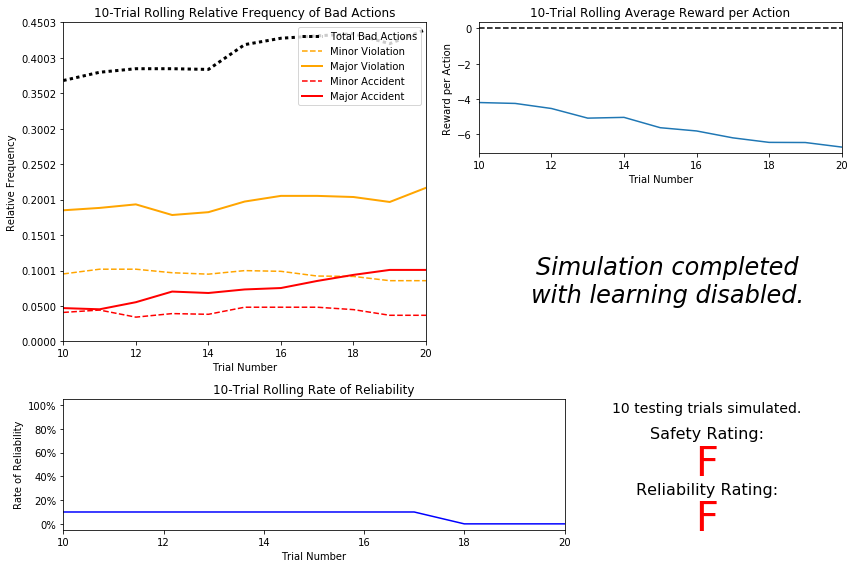

In [3]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

The agent is making bad decisions almost 40 to 50% of the time, which caused minor accidents 5% of the time and major accidents between 5 and 10% of the time. 

The rate of reliability does make sense: as the agent is driving randomly, we are never sure to reach our destination and in fact, the reliability graph shows we are late in almost 90% of the time.

The agent is receiving a negative mean reward per action, that decreases over time, which seems to correlate with the increasing number of major accidents and the decrease in reliability. The agent is not 'heavily' penalised for its actions as it does not learn from previous accidents and choses a path at random.

The outcome of results does not change much over time as the number of trials increases: bad actions seem to be rather constant as well as the poor reliability: this smartcab would not be considered safe for its passengers as most of the travels result in violations or accidents, while arriving late at its destination.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

To my mind, the most relevant features for learning both safety and efficiency are the following:
- *waypoint* (for efficiency): in order to minimize the time spent to get to its destination, the smartcab must know which direction to head to.
- *inputs > light*: as seen in the first question, light colors are directly linked to rewards as the vehicle is penalized if, for example, it crosses a red light or when it chooses to stay idle on a green light with no traffic.
- *inputs > left*: if there is a vehicle on our left and our lights are red and we initiate a turn right, the smartcab must learn that taking this kind of action will result in an accident.
- *inputs > oncoming*: this feature is rather important as our smartcab must learn that if the lights are green and it wants to turn left, it must check if there is no oncoming traffic

The deadline feature is not appropriate for both safety and efficiency: the agent will learn about it progressively as it will try to find a way to improve reliability using the Q table. But in the first place, this parameter is not related to safety. Also, if we were to include the deadline into our current state, we could suffer from the curse of dimensionality as our state space would blow up really quickly.

The *inputs > right* feature is not relevant here, as the presence of a car on our right does not impact us at all. In light='red' cases, the only move allowed is to turn right, but we would be in the opposite lane from the other vehicle. In light='green' cases, we have right-of-way to turn left, go forward or go right.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

Given the answer to question 4, let's make an assessment of all the possible states offered by each feature:
- *waypoint*: 3 (forward, left, right)
- *inputs > light*: 2 (red, green)
- *inputs > left*: 4 (None, forward, left, right)
- *inputs > oncoming*: 4 (None, forward, left, right)

The number of possible combinations for each state is therefore 3x2x4x4=96

The agent can learn a policy for each possible state within reasonable time as 96 combinations are not that many for a 2017 computer.

### Update the Driving Agent State
We need to navigate to the `'build_state()'` agent function. We will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. We will confirm our driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: for every state the agent visits, we will create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, we will update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, we will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor.

The agent attribute `self.Q` is a dictionary: this is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

As a *decaying* $\epsilon$ *(exploration) factor*, and as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, we will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, we adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

We use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$


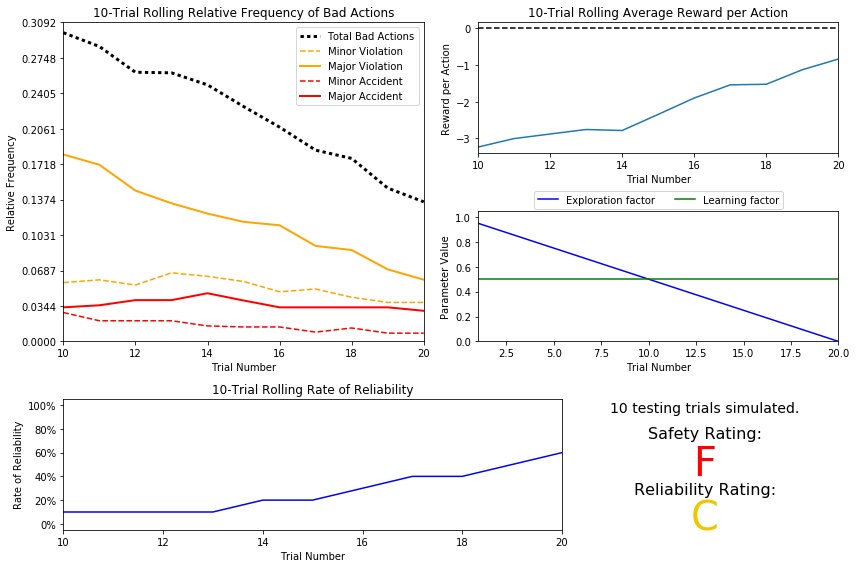

In [6]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

- The first notable difference between the non-training agent and the basic Q-learner can be seen on the 'frequency of bad actions' graph: the overall frequency drops as we make more trials, which shows that the system is learning and avoiding new mistales as it is trained. The rate of reliability graph confirms this thoughts as the reliability increases progressively from 15 to nearly 60% at the end of the trials, yielding a rating of C (instead of F before)

- The driving agent required 20 training trials before testing; it makes sense as we set the decay function to substract 0.05 at the end of each trial. After 20 trials, we are therefore below our epsilon tolerance (0 < 0.05) and can start testing.

- The decaying function is accurately represented as the exploration factor curve, evolving from 1 to 0 in 20 trials.

- The average reward per action also improves from -3 to -1 throughout the trials, showing that the agent adapts to new situations based on the rewards from previous experiences.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on our Q-Learning implementation, we need to consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, we will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, we will try and use multiple decaying functions for $\epsilon$ (the exploration factor). They all decay to `'tolerance'` at a reasonable rate. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions ($t$ is the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
We will also use a decaying function for $\alpha$ (the learning rate), which must adhere to the inequality $0 \leq \alpha \leq 1$.

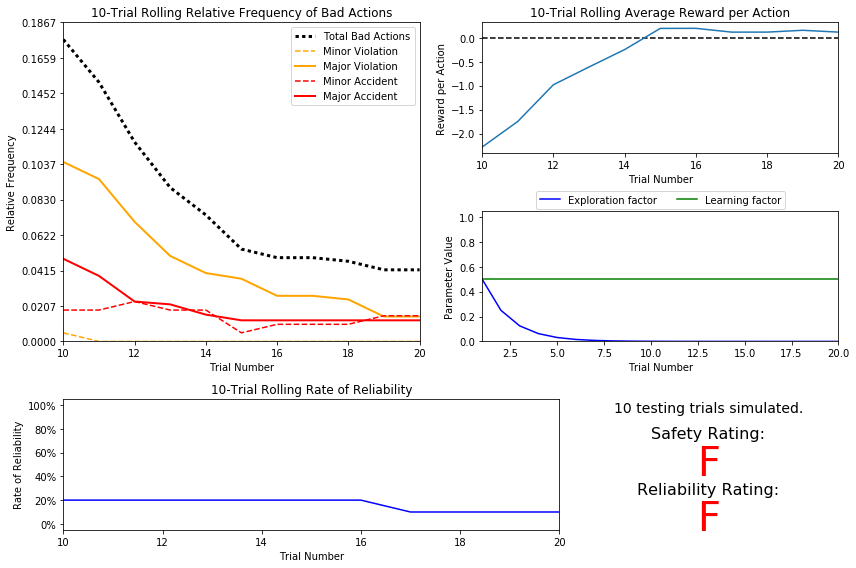

In [3]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_epsilonat-alpha05-tolerance005.csv')

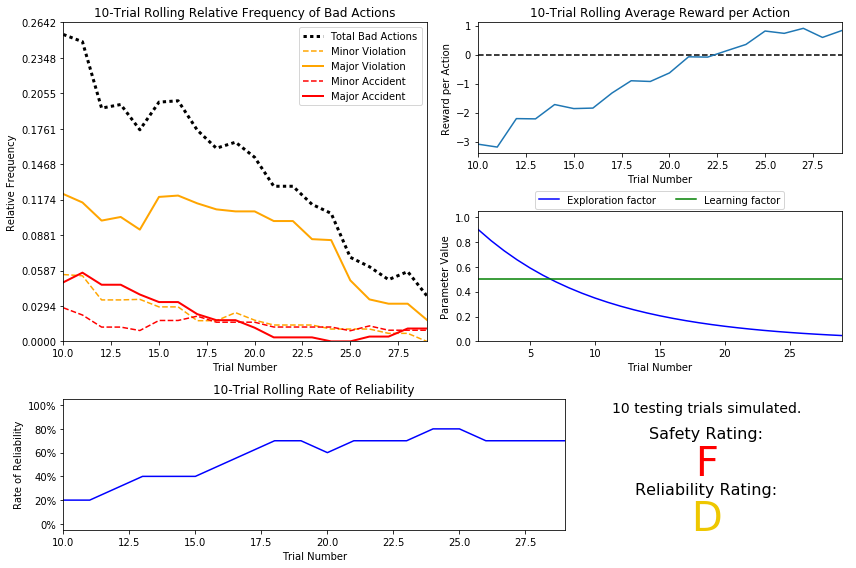

In [4]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_epsilon09t-alpha05-tolerance005.csv')

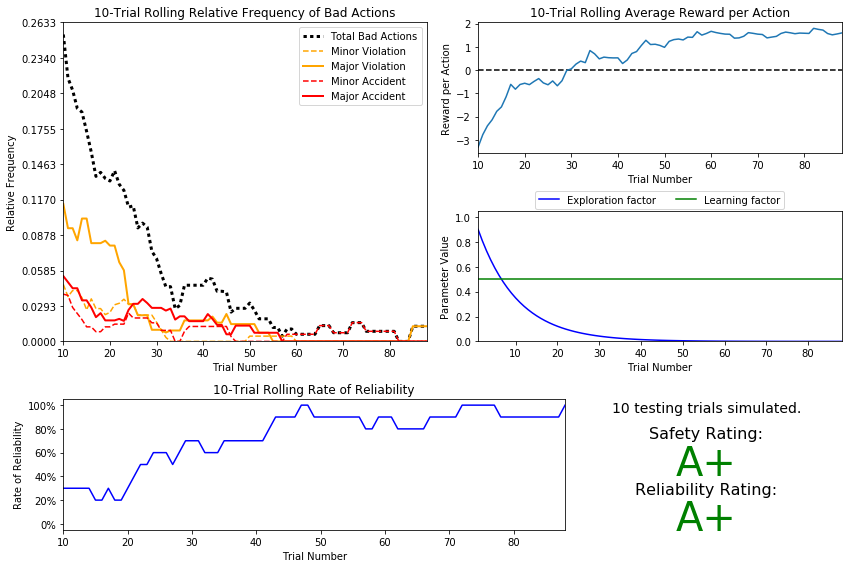

In [5]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_epsilon09t-alpha05-tolerance00001.csv')

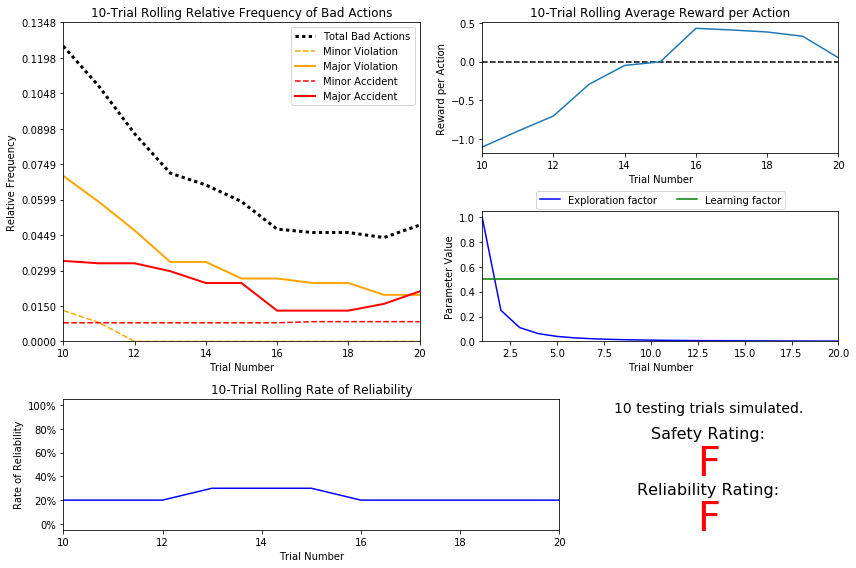

In [6]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_epsilon1t2-alpha05-tolerance005.csv')

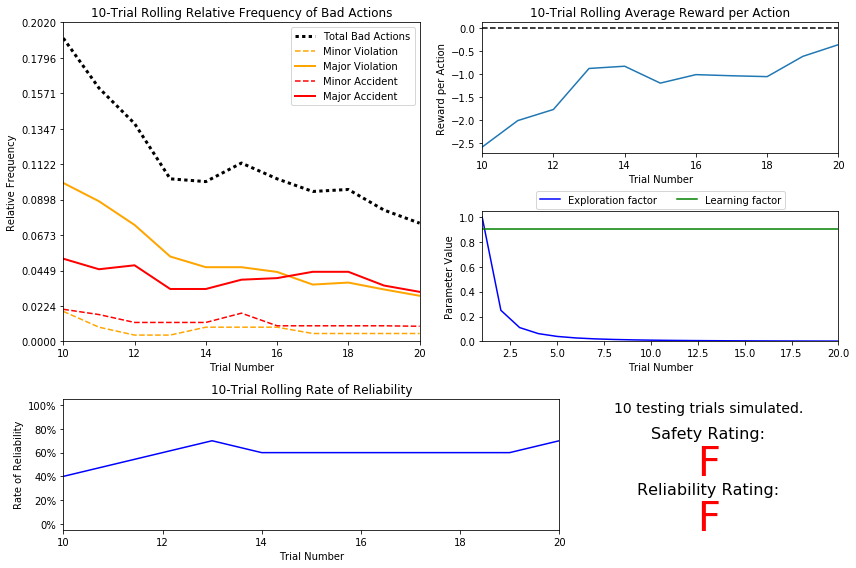

In [7]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_epsilon1t2-alpha09-tolerance005.csv')

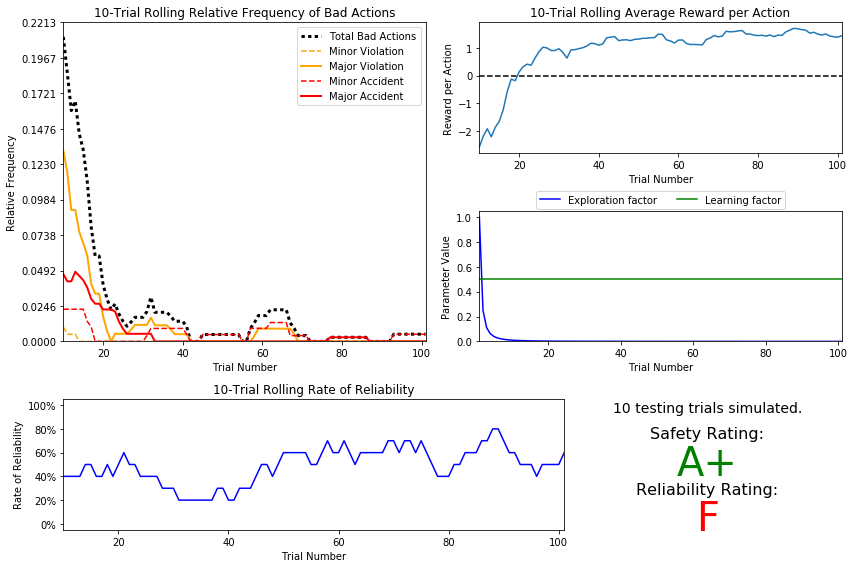

In [8]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_epsilon1t2-alpha05-tolerance00001.csv')

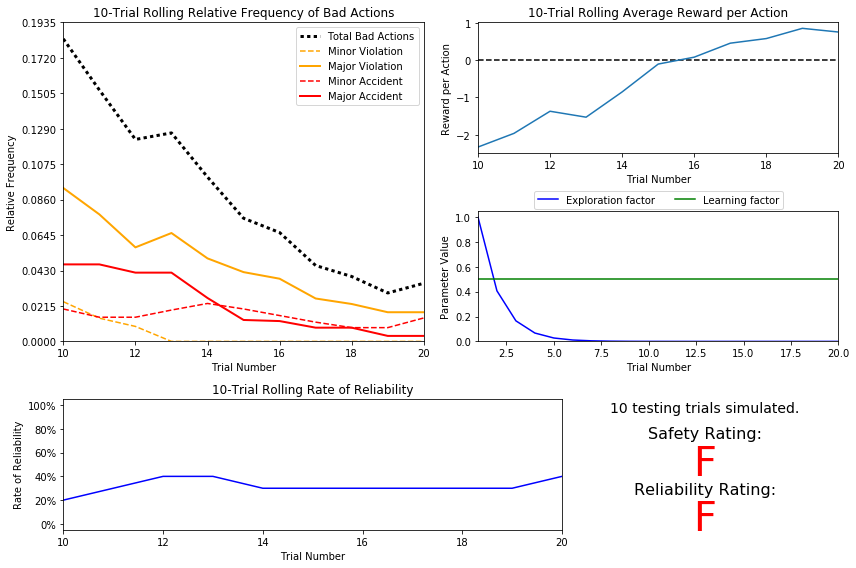

In [10]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_epsilonE09t-alpha05-tolerance00001.csv')

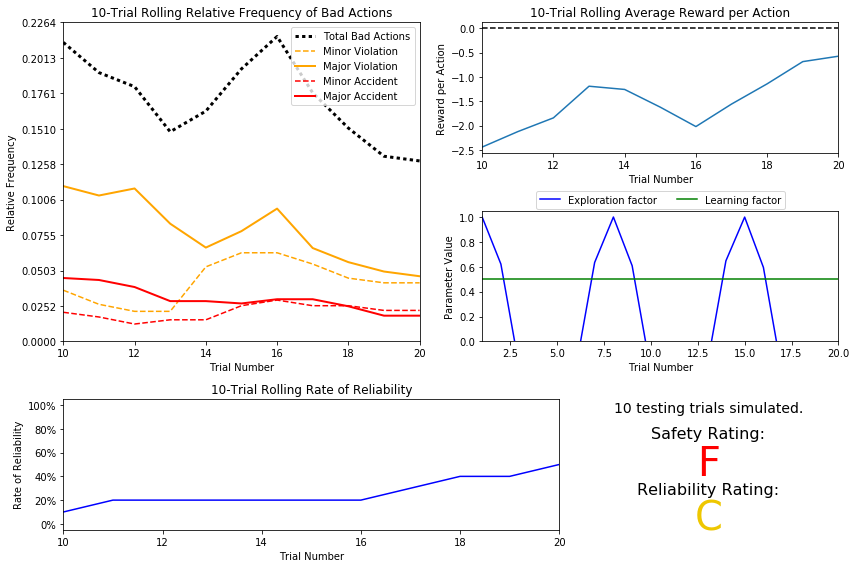

In [11]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_epsiloncos09t-alpha05-tolerance00001.csv')

- I made 8 attempts to test all the above-listed epsilon decaying functions with various alpha and tolerance values combinations. I got the best results in terms of both safety and reliability with the epsilon=a\*\*t function, the default alpha value (0.5) and a very low tolerance of 0.0001. The results presented below use this configuration.
- To be able to reach the low tolerance value I had set to 0.0001, the agent required 90 trial runs before starting the testing phase: 0.9\*\*90 = 7e-5 < 1e-4. I did not change the default alpha value on this run.
- I chose this combination of decaying function and tolerance so that the decay happens not too fast and smoothly tend to the tolerance value (aswe can see in the parameters panel) so that it lets the system learn correctly, but in a fair amount of time. We can see from the other runs I made, that the other decaying functions generally drop too fast, while having a hard time reaching the tolerance value and learning very few during the process. 
- In the 'default learning' simulation, the bad actions frequency went down from 30% to 15% in 20 trials, with a reliability improving from 15 to almost 60%. With the optimized learning, the beginning of the simulation is more or less the same: the bad actions percentage drops from 30% to 15% over the first 20 trials, but continues to decrease very fast to the point where it stabilizes to 1%. Reliability increases more slowly (30 to 60% in 30 trials) but surely to over 90% in 50 trials, and stabilizing, yielding an A+ rate. 
- The fact that both bad action frequency and reliability scores tend to 'stabilize' in time show that our Q-learner successfully learned how to react in the most common states it encounters. 
- With both A+s in safety and reliability, we could say that our cab is fast and safe !

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, we can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, we can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to our advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

In the state (forward, red, None, None), where our cab stands at a red light waiting to go straight and no other cars are involved, the Q-learner should provide the highest Q-value to the 'None' action (do nothing), which is the optimal policy, given that the red light forbids us to do anything. 

The 'sim_improved-learning.txt' file confirms these thoughts:

```
('forward', 'red', None, None)
-- forward : -4.78
-- right : 0.54
-- None : 1.90
-- left : 0.00
```
 The 'None' Q-value (1.90) dominates all others, and corresponds to the optimal policy explained above.
 
 Another example I found involves a suboptimal policy:
 
 ```
 ('left', 'red', None, None)
 -- forward : -8.02
 -- right : 0.24
 -- None : 0.00
 -- left : 0.00
 ```
 In this one, our intent is to go left after waiting at a red light, with no traffic oncoming nor on our left. The right policy would be to wait at the light ('None', as we do not want to go right), however, the maximum Q-value here is set to 'right' (0.24). It is suboptimal as the action is authorized, however it is not the required direction.  